# KERAS and TENSORFLOW-THEANO
TUTORIAL: Applying the regression previously obtained
(%lsmagic for magic commanda and ! for bash instruction)

In [1]:
# We start by importing all the necessary packages
import sys;
import os, sys, array, re, math, random, subprocess, glob
from math import *
import numpy as np
import scipy
from numpy.lib.recfunctions import stack_arrays
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import cPickle
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.utils import compute_class_weight
from sklearn.model_selection import KFold
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, Highway, MaxoutDense, Masking, GRU, Merge, Input, merge
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils.np_utils import to_categorical
from keras.wrappers.scikit_learn import KerasRegressor
import deepdish.io as io
import ROOT
from ROOT import gSystem, gROOT, gApplication, TFile, TTree, TCut, TH1F, TCanvas
from root_numpy import root2array 
from IPython.display import HTML, IFrame
import seaborn as sns; sns.set()
print "I you had no error so far, this is great! We can start the tutorial."

Using Theano backend.


Welcome to JupyROOT 6.08/06
I you had no error so far, this is great! We can start the tutorial.


/Users/Luca2/Library/Python/2.7/lib/python/site-packages/root_numpy/__init__.py:34: RuntimeWarning: ROOT 6.08/06 is currently active but you installed root_numpy against ROOT 6.08/00. Please consider reinstalling root_numpy for this ROOT version.
  RuntimeWarning)
/Users/Luca2/Library/Python/2.7/lib/python/site-packages/root_numpy/__init__.py:46: RuntimeWarning: numpy 1.12.1 is currently installed but you installed root_numpy against numpy 1.11.0. Please consider reinstalling root_numpy for this numpy version.
  RuntimeWarning)


We set some variables we will use later

In [2]:
# Check this file out, it contains many functions we will use.
execfile("Useful_func.py")
# We start loading the regression weights
model_Lead    = load_model('models/Weights_regression_LeadingJet.h5')
model_SubLead = load_model('models/Weights_regression_SubleadingJet.h5')
# Parameters
folder='Plots_Regression_Applied/' # Folder with Plots
MakePlots=True # Set False if you want to run faster
folderCreation  = subprocess.Popen(['mkdir -p ' + folder], stdout=subprocess.PIPE, shell=True); folderCreation.communicate()
folderCreation2 = subprocess.Popen(['mkdir -p models/'], stdout=subprocess.PIPE, shell=True); folderCreation2.communicate()


('', None)

Now We Start manipulating ROOT files into a format we can use to train a MVA

In [3]:
# 0) We first have to place in alist the files we would like to apply the regression too.
Input_Files = ['MVA_GluGluToRadionToHHTo2B2VTo2L2Nu_M-500_narrow_13TeV-madgraph-v2.root']
# 1) Place a selection if you want to use it
my_selec = 'met_pt>20 && met_pt<500 && muon1_pt>20 && muon2_pt>10 && fabs(muon1_eta)<2.4 && fabs(muon2_eta)<2.4 && pt_l1l2<500 && pt_b1b2<500 && mass_l1l2>12 && mass_l1l2<500 && mass_b1b2<500 && b1jet_pt>20 && fabs(b1jet_eta)<2.4 && b2jet_pt>20 && fabs(b2jet_eta)<2.4 && mass_trans>10 && mass_trans<500 && HT<4000'
# 2) Selecting the branches that contains the information we want to use (in general)
my_branches_jet1 = ["numOfVertices","b1jet_pt","b1jet_eta","b1jet_mt","b1jet_leadTrackPt","b1jet_leptonDeltaR","b1jet_leptonPtRel","b1jet_leptonPt","b1jet_vtxPt","b1jet_vtxMass","b1jet_vtxNtracks","b1jet_neHEF","b1jet_neEmEF","b1jet_vtx3DSig","b1jet_vtx3DVal","b1genjet_pt"]
my_branches_jet2 = ["numOfVertices","b2jet_pt","b2jet_eta","b2jet_mt","b2jet_leadTrackPt","b2jet_leptonDeltaR","b2jet_leptonPtRel","b2jet_leptonPt","b2jet_vtxPt","b2jet_vtxMass","b2jet_vtxNtracks","b2jet_neHEF","b2jet_neEmEF","b2jet_vtx3DSig","b2jet_vtx3DVal","b2genjet_pt"]
# 3) Selecting the branches that contains the information we want to use (in the training)
my_branches_training_jet1 = my_branches_jet1
my_branches_training_jet2 = my_branches_jet2
# Converting Root files in dataframe (Very useful, checnl root2panda in Useful_func.py)
LeadJet    = root2panda('files'+Input_Files[0], 'DiHiggsWWBBAna/evtree', branches=my_branches_jet1, selection=my_selec_jet1)
SubLeadJet = root2panda('files'+Input_Files[0], 'DiHiggsWWBBAna/evtree', branches=my_branches_jet2, selection=my_selec_jet2)


---> hh Displayed as panda dataframe: 
      numOfVertices    b1jet_pt  b1jet_eta    b1jet_mt  b1jet_leadTrackPt  \
0                19  173.124298  -0.714916  173.738297          47.906250   
1                33  246.682297   0.298446  248.075989          58.843750   
2                30  340.403229   1.258016  342.380005          98.562500   
3                14   80.552818   2.200674   81.073486          22.250000   
4                16   86.618324  -1.492352   87.986191          10.437500   
5                29  147.646530   0.765988  148.593613          38.468750   
6                20  179.774414  -0.576904  181.731323          33.406250   
7                13  160.337036  -0.464420  162.175751          36.437500   
8                16   67.824074   1.615699   68.589928          27.625000   
9                13  118.275604  -1.762509  119.216217          32.031250   
10               42  174.260849   1.073892  176.100327          26.484375   
11               33  142.049393   2.3

You need:
1. X : matrix with raw=#Events and column=Variables to discriminate."
2. w : A vector containig the weights of each event"
3. Y : A vector containing the target: genPt/recoPt. This is the weight you will then apply to the recoPt

In [6]:
print('Now lets start to talk about DNN!')
# Turn the df the desired ndarray "X" that can be directly used for ML applications.
X    = LeadJet[my_branches_training_jet1].as_matrix() # Each row is an object to classify, each column corresponds to a specific variable.
if (doSubLead):
    X = SubLeadJet[my_branches_training_jet2].as_matrix()
# No weights needed, just set al to 1
w    =  np.ones(X.shape[0])
# This is the array with the true values: 0 is signal, 1 if TT.
y = LeadJet["target"]
if (doSubLead):
  y = SubLeadJet["target"]

# Randomly shuffle and automatically split all your objects into train and test subsets
ix = range(X.shape[0]) # array of indices, just to keep track of them for safety reasons and future checks
X_train, X_test, y_train, y_test, w_train, w_test, ix_train, ix_test = train_test_split(X, y, w, ix, train_size=0.7) # Train here is 70% of the total statistic
# It is common practice to scale the inputs to Neural Nets such that they have approximately similar ranges (it atually improve the results)
scaler = StandardScaler() 
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test) # You are applying the same transformation done to X_train, to X_test.

Now lets start to talk about DNN!


In [7]:
# This takes a while, but it is worth do do it once. It shows the correlations for S and B overimposed.
# More variables you add in var_toPlot, more times it takes.
if MakePlots:
    # Next lines to select the same number of entries
    var_toPlot = ["target","numOfVertices","b1jet_pt","b1jet_eta","b1jet_mt","b1jet_leadTrackPt","b1jet_leptonDeltaR","b1jet_leptonPtRel","b1jet_leptonPt","b1jet_vtxPt","b1jet_vtxMass","b1jet_vtxNtracks","b1jet_neHEF","b1jet_neEmEF","b1jet_vtx3DSig","b1jet_vtx3DVal","b1genjet_pt"]
    if (doSubLead):
        var_toPlot = ["target","numOfVertices","b2jet_pt","b2jet_eta","b2jet_mt","b2jet_leadTrackPt","b2jet_leptonDeltaR","b2jet_leptonPtRel","b2jet_leptonPt","b2jet_vtxPt","b2jet_vtxMass","b2jet_vtxNtracks","b2jet_neHEF","b2jet_neEmEF","b2jet_vtx3DSig","b2jet_vtx3DVal","b2genjet_pt"]
    # You can select the variable to plot in sns.pairplot using an argumnet vars=['var1','var2'...]
    sns_plot = sns.pairplot(LeadJet,palette=["#e74c3c"],plot_kws={"s": 3,"alpha":0.3},size=5)
    sns_plot.savefig(folder + "/Variables_pairplot_LeadingJet.pdf")

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [8]:
# Regression
def baseline_model():
    model = Sequential()
    model.add(Dense(10, input_dim=X_train.shape[1], activation='relu')) # Linear transformation of the input vector. The first number is output_dim.\n",
    model.add(Dropout(0.1)) # To avoid overfitting. It masks the outputs of the previous layer such that some of them will randomly become inactive and will not contribute to infor
    model.add(Dense(20, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(20, activation='sigmoid'))
    model.add(Dropout(0.1))
    model.add(Dense(10,activation='tanh'))
    model.add(Dropout(0.1))
    model.add(Dense(20, activation='sigmoid'))
    model.add(Dropout(0.1))
    model.add(Dense(1))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.summary()
    return model
# evaluate model with standardized dataset
estimator = KerasRegressor(build_fn=baseline_model, nb_epoch=100, batch_size=15, verbose=0)
print "Now fitting the Train sample to get our model"
estimator.fit(X_train,y_train)

Now fitting the Train sample to get our model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                170       
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                220       
_________________________________________________________________
dropout_2 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 20)                420       
_________________________________________________________________
dropout_3 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_4 (Dense)              (

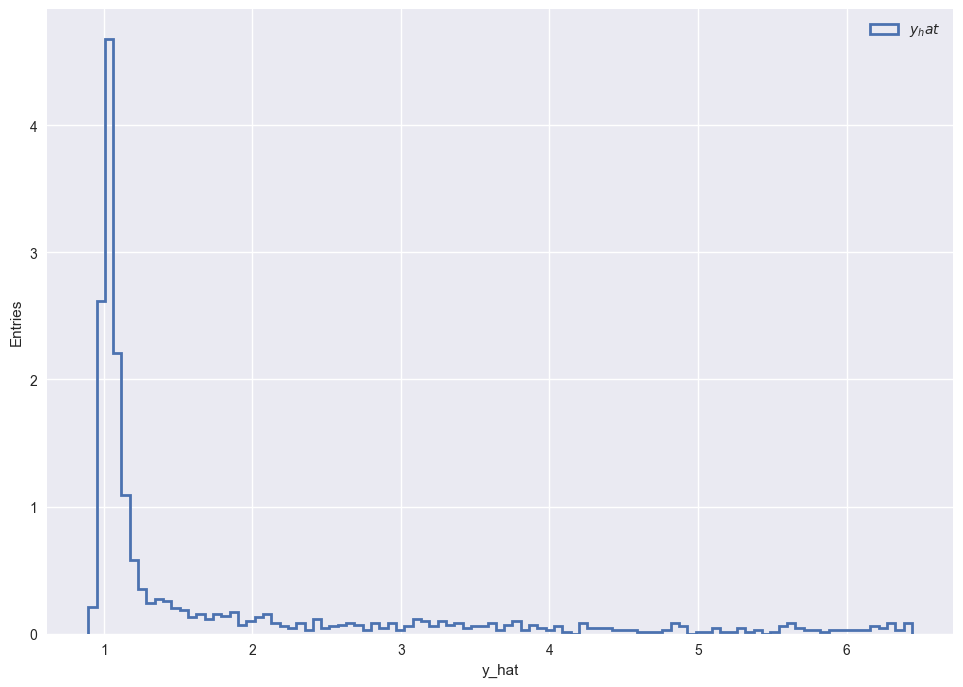

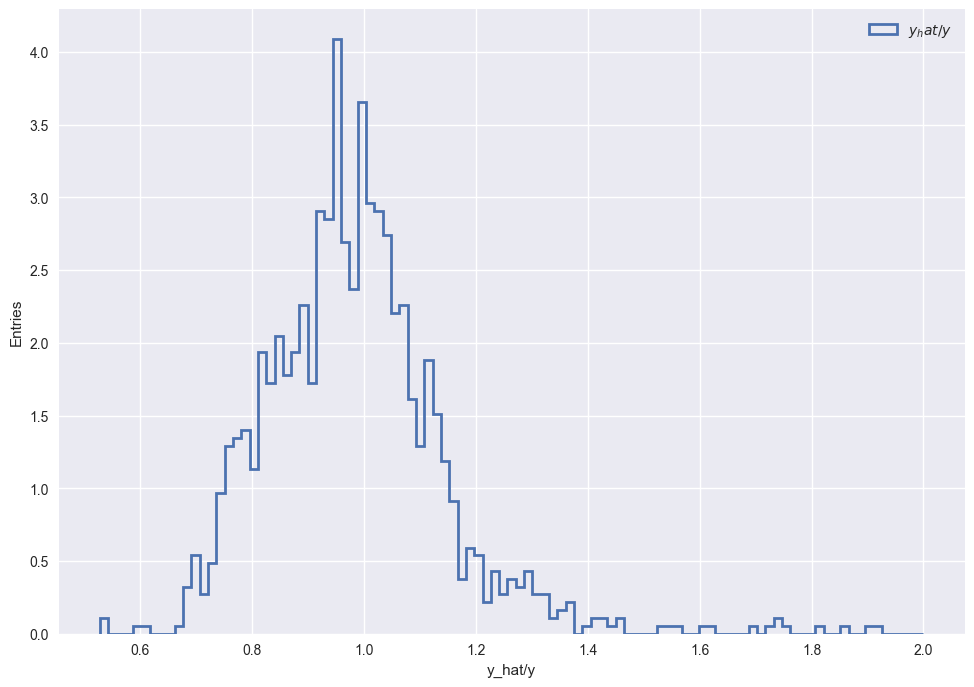

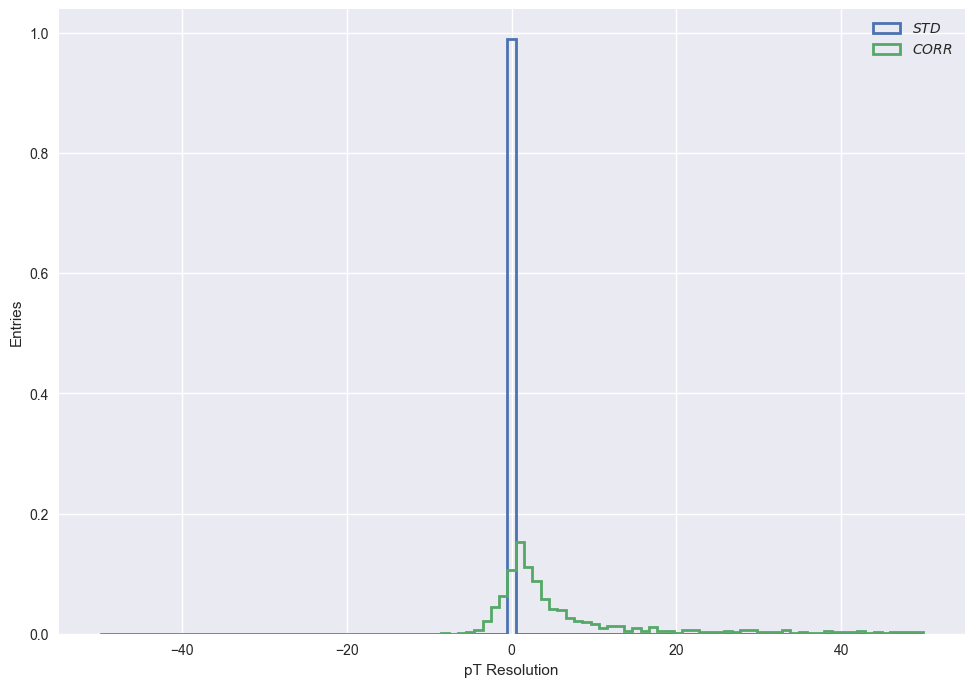

score: 0.1970435606
('Saving:', 'Plots_Regression//Regression_y_hat.pdf')
('Saving:', 'Plots_Regression//Regression_y_hat_OverY.pdf')
WARNING. Pt Feature not found!!


In [9]:
# Get a prediction on the test
y_hat = estimator.predict(X_test)
# Get the score
score = estimator.score(X_test, y_test)
print "score:", score

# Plot the test target and the estimated one
%matplotlib inline
if MakePlots:
    # Estimatd target
    matplotlib.rcParams.update({'font.size': 16})
    fig = plt.figure(figsize=(11.69, 8.27), dpi=100)
    bins = np.linspace(my_max(min(y_hat),0.), max(y_hat), 100)
    _ = plt.hist(y_hat,  bins=bins, histtype='step', normed=True, label=r'$y_hat$', linewidth=2)
    plt.xlabel("y_hat")
    plt.ylabel('Entries')
    plt.legend(loc='best')
    print('Saving:',folder + '/Regression_y_hat.pdf')
    plt.savefig(folder + '/Regression_y_hat.pdf')
    # Estimatd target/ True target
    matplotlib.rcParams.update({'font.size': 16})
    fig = plt.figure(figsize=(11.69, 8.27), dpi=100)
    bins = np.linspace(my_max(min(y_hat/y_test),0.), 2, 100)
    _ = plt.hist(y_hat/y_test,  bins=bins, histtype='step', normed=True, label=r'$y_hat/y$', linewidth=2)
    plt.xlabel("y_hat/y")
    plt.ylabel('Entries')
    plt.legend(loc='best')
    print('Saving:',folder + '/Regression_y_hat_OverY.pdf')
    plt.savefig(folder + '/Regression_y_hat_OverY.pdf')
    # Pt Resolution Before After (first I have to find the index in X_test that corresponf to the Jet and Genjet pT)
    N_bjet_pt = -1; N_bgenjet_pt = -1
    N_tmp = 0
    for Feature in my_branches_training_jet1:
        if(not doSubLead and Feature=="b1jet_pt"): N_bjet_pt = N_tmp
        if(not doSubLead and Feature=="b1genjet_pt"): N_bgenjet_pt = N_tmp
        if(doSubLead and Feature=="b2jet_pt"): N_bjet_pt = N_tmp
        if(doSubLead and Feature=="b2genjet_pt"): N_bgenjet_pt = N_tmp
        N_tmp += 1
    if( N_bjet_pt==-1 or N_bgenjet_pt==-1 ): print "WARNING. Pt Feature not found!!"
    X_test_ori = scaler.inverse_transform(X_test) # Need also to trasform back the X_test
    bjet_pt = X_test_ori[:,N_bjet_pt]
    bgenjet_pt = X_test_ori[:,N_bgenjet_pt]
    Variable       = (bjet_pt-bgenjet_pt)       
    Variable_corr  = (bjet_pt*y_hat-bgenjet_pt) 
    Variable_ideal = (bjet_pt*y_test-bgenjet_pt)
    matplotlib.rcParams.update({'font.size': 16})
    fig = plt.figure(figsize=(11.69, 8.27), dpi=100)
    bins = np.linspace(-50, 50, 100)
    _ = plt.hist(Variable,  bins=bins, histtype='step', normed=True, label=r'$STD$', linewidth=2)
    _ = plt.hist(Variable_corr,  bins=bins, histtype='step', normed=True, label=r'$CORR$', linewidth=2)
    #You chan check if this below is a single Bin in 0
    #_ = plt.hist(Variable_ideal,  bins=bins, histtype='step', normed=True, label=r'$IDEAL$', linewidth=2)
    plt.xlabel("pT Resolution")
    plt.ylabel('Entries')
    plt.legend(loc='best')
    plt.savefig(folder + '/Regression_PtRes.pdf')

#kfold = KFold(n_splits=10, random_state=seed)
#results = cross_val_score(estimator, X, Y, cv=kfold)
#print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

In [10]:
# Now save this model into a file
name = "Weights_regression_LeadingJet.h5"
if doSubLead: name = "Weights_regression_SubleadingJet.h5"
model.save(folder + '/' + name)

NameError: name 'model' is not defined